In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All"
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/transformers-training/bert_base_nli_mean_tokens.h5
/kaggle/input/transformers-training/roberta-large-nli-stsb-mean-tokens.h5
/kaggle/input/transformers-training/__results__.html
/kaggle/input/transformers-training/multi-qa-mpnet-base-dot-v1.h5
/kaggle/input/transformers-training/model_miniLM.h5
/kaggle/input/transformers-training/__notebook__.ipynb
/kaggle/input/transformers-training/__output__.json
/kaggle/input/transformers-training/custom.css
/kaggle/input/models/bert_base_nli_mean_tokens.h5
/kaggle/input/models/roberta-large-nli-stsb-mean-tokens.h5
/kaggle/input/models/multi-qa-mpnet-base-dot-v1.h5
/kaggle/input/models/model_miniLM.h5
/kaggle/input/imdb-dataset-embeddings-by-sentence-transformers/imdb_dataset_df_2_embeddings (MiniLM).npy
/kaggle/input/imdb-dataset-embeddings-by-sentence-transformers/imdb_dataset_df_2_embeddings_multi-qa-mpnet-base-dot-v1.npy
/kaggle/input/imdb-dataset-embeddings-by-sentence-transformers/imdb_dataset_df_1_embeddings_roberta_large.npy
/

# A. Exploratory Data Analysis

 This is a dataset for binary sentiment classification task containing **50000** data points. I divided it into two sets: 25000 each for training and testing. It has 2 columns `review` and `sentiment`. The `review` column has textual data of variable lengths and `sentiment` column contains two values: `positive` and `neagtive`.

In [ ]:
df = pd.read_csv('/kaggle/input/imdb-dataset-of-50k-movie-reviews/IMDB Dataset.csv')

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   review     50000 non-null  object
 1   sentiment  50000 non-null  object
dtypes: object(2)
memory usage: 781.4+ KB


In [ ]:
df.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


In [ ]:
df.isnull().sum()

review       0
sentiment    0
dtype: int64

## 1. Distribution of Sentimnets

As this dataset has equal number of positive and negative reviw so this is a balanced dataset.

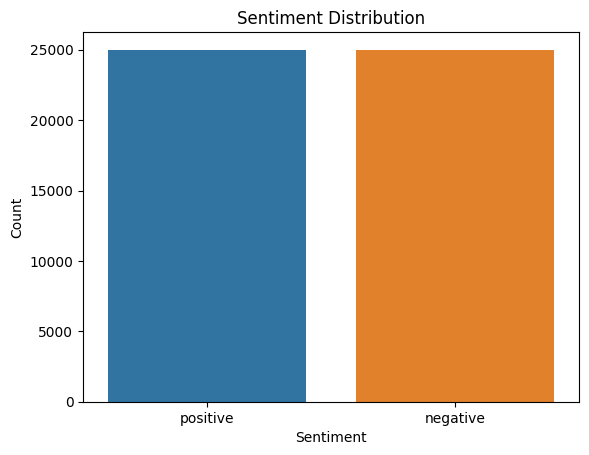

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Count plot for sentiment distribution
sns.countplot(x='sentiment', data=df)
plt.title('Sentiment Distribution')
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.show()


## 2. Review Lengths By Sentiment

To analyze the length of reviews, a histogram can show the distribution of  review lengths.

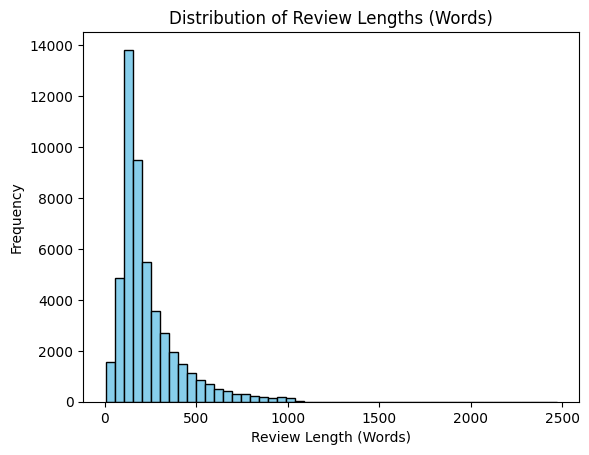

In [ ]:
# Calculate review lengths
df['review_length'] = df['review'].apply(lambda x : len(x.split()))

# Histogram for review lengths
plt.hist(df['review_length'], bins=50, color='skyblue', edgecolor='black')
plt.title('Distribution of Review Lengths (Words)')
plt.xlabel('Review Length (Words)')
plt.ylabel('Frequency')
plt.show()


## 3. Label Encoding of Sentiment Column

The label column, `sentiment,` has either `positive` or `negative` values, so it needs to be converted into numerical form. Therefore, I opted for the label encoder method, which encodes the `positive` as `1` and `negative` as `0`.

In [ ]:
from sklearn.preprocessing import LabelEncoder

# Initialize the label encoder
label_encoder = LabelEncoder()

# Label encoding of sentiment column
df['encoded_sentiment'] = label_encoder.fit_transform(df['sentiment'])

# Assign the encoded sentiments to the y variable
y = df['encoded_sentiment']


## 4. Text Cleaning

The review column has raw textual data with punctuation marks, unnecessary characters, URLs etc. Cleaning the data helps in reducing noise in the data which can improve the performance of text-analysis tasks like sentiment Analysis. I imported the `re` method for this purpose

In [ ]:
import re

def remove_special_characters(text):
    # Remove special characters except whitespace and alphanumeric characters
    text = re.sub(r'[^\w\s]', ' ', text)
    # Replace multiple whitespace characters with a single space
    text = re.sub(r'\s+', ' ', text).strip()
    # Remove URLs
    text = re.sub(r'http\S+', '', text)
    # Remove digits
    text = re.sub(r'\d', ' ', text)
    # Remove the word 'br' (commonly found in HTML text, e.g., <br />)
    text = re.sub(r'\bbr\b', ' ', text)
    # List of common words to remove
    common_words = ['film', 'movie']
    # Construct a regular expression pattern to match any of the common words as whole words
    pattern = r'\b(?:' + '|'.join(map(re.escape, common_words)) + r')\b'
    # Remove common words from the text
    text = re.sub(pattern, ' ', text)
    return text


## 5. Removing English Stopwords

In [ ]:
import nltk
from nltk.corpus import stopwords

# Download the stopwords corpus
nltk.download('stopwords')

# Load the stopwords for English
stop_words = set(stopwords.words('english'))

# Apply stopwords removal to the 'review' column
df['review'] = df['review'].apply(lambda x: ' '.join([word for word in x.split() if word.lower() not in stop_words]))


[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## 6. Word Tokenization

In [ ]:
# Tokenize the review column
from nltk import word_tokenize
df['tokens'] = df['review'].apply(word_tokenize)

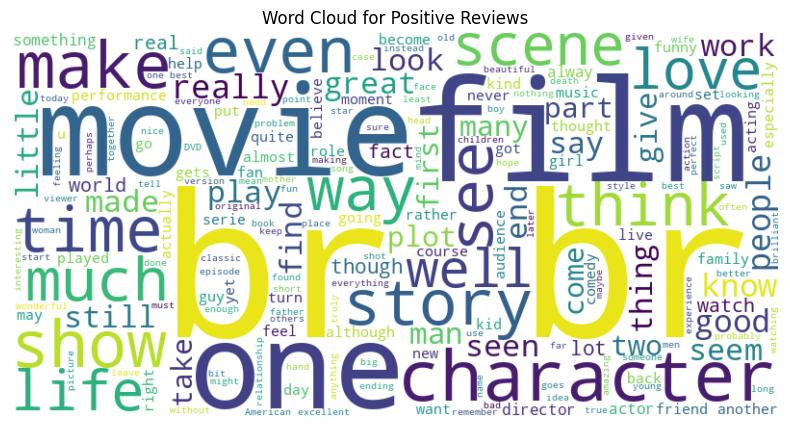

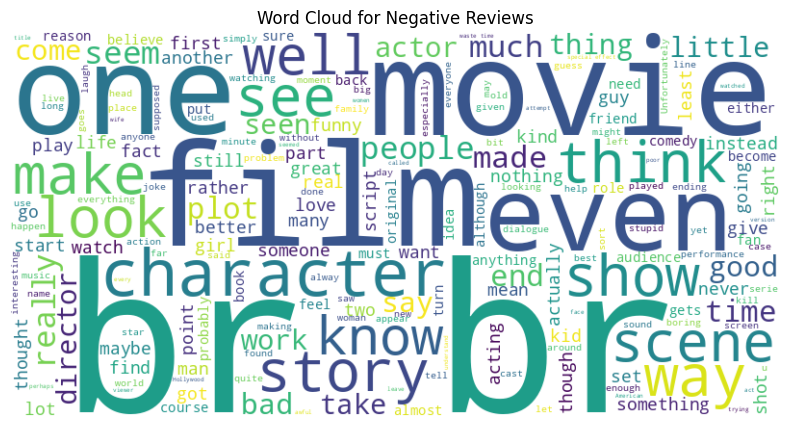

In [ ]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Function to plot word frequency as a word cloud
def plot_word_cloud(corpus, title):
    # Join all reviews into a single string
    text = ' '.join(corpus)

    # Generate word cloud
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)

    # Plot word cloud
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title(title)
    plt.axis('off')
    plt.show()

# Word cloud for positive reviews
plot_word_cloud(df[df['sentiment'] == 'positive']['review'], 'Word Cloud for Positive Reviews')

# Word cloud for negative reviews
plot_word_cloud(df[df['sentiment'] == 'negative']['review'], 'Word Cloud for Negative Reviews')


In [ ]:
import warnings

# Ignore all warnings
warnings.filterwarnings("ignore")

#
X = df['review']
y = df['encoded_sentiment']

# B. Train-Test-Split

In machine learning, it's essential to split the dataset into training and testing sets to evaluate the performance of the model. The `train_test_split` function from the `sklearn.model_selection` module helps us accomplish this task efficiently. I set the train_size to `50%`.

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_valid, y_train, y_valid = train_test_split(X, y, random_state=42, train_size=0.5)

# C. Word Vector and Embedding Algorithms


Text data is inherently unstructured, making it challenging for machine learning algorithms to process effectively. To overcome this challenge, we employ word vectorization and embedding techniques.

By converting text data into numerical representations, we enable machine learning models to understand and analyze textual information. This process, known as vectorization, transforms each word or sentence into a numeric vector, where each dimension of the vector represents a unique aspect or feature of the text.

These numerical representations capture semantic relationships between words, enabling models to learn complex patterns and relationships within the text. As a result, machine learning algorithms can perform tasks such as text classification, sentiment analysis, and information retrieval with greater accuracy and efficiency.

In this context, various algorithms play a crucial role in generating meaningful word embeddings and facilitating the processing of text data by machine learning models.

In this notebook I used the followig:

1. **CountVectorizer**
2. **Term frequency-Inverse Document Frequency**
3. **Word2Vec**
4. **GloVe**
5. **Sentence Transformers**

   a. **all-MiniLM-L6-v2**
   
   b. **bert-base-nli-mean-tokens**
   
   c. **roberta-large-nli-stsb-mean-tokens**

## 1. Count Vectorizer (Bag of words)

It converts a collection of text documents to a matrix of token counts. It is also known  `Bag Of Words(BOW),` but it loses the word index.


In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
# Initialize the TfidfVectorizer

vectorizer = CountVectorizer()

# Fit and transform the training data
X_train_vec = vectorizer.fit_transform(X_train)

# Transform the validation data
X_valid_vec = vectorizer.transform(X_valid)

# Check the shapes of the transformed data
print(X_train_vec.shape)
print(X_valid_vec.shape)

(25000, 76630)
(25000, 76630)


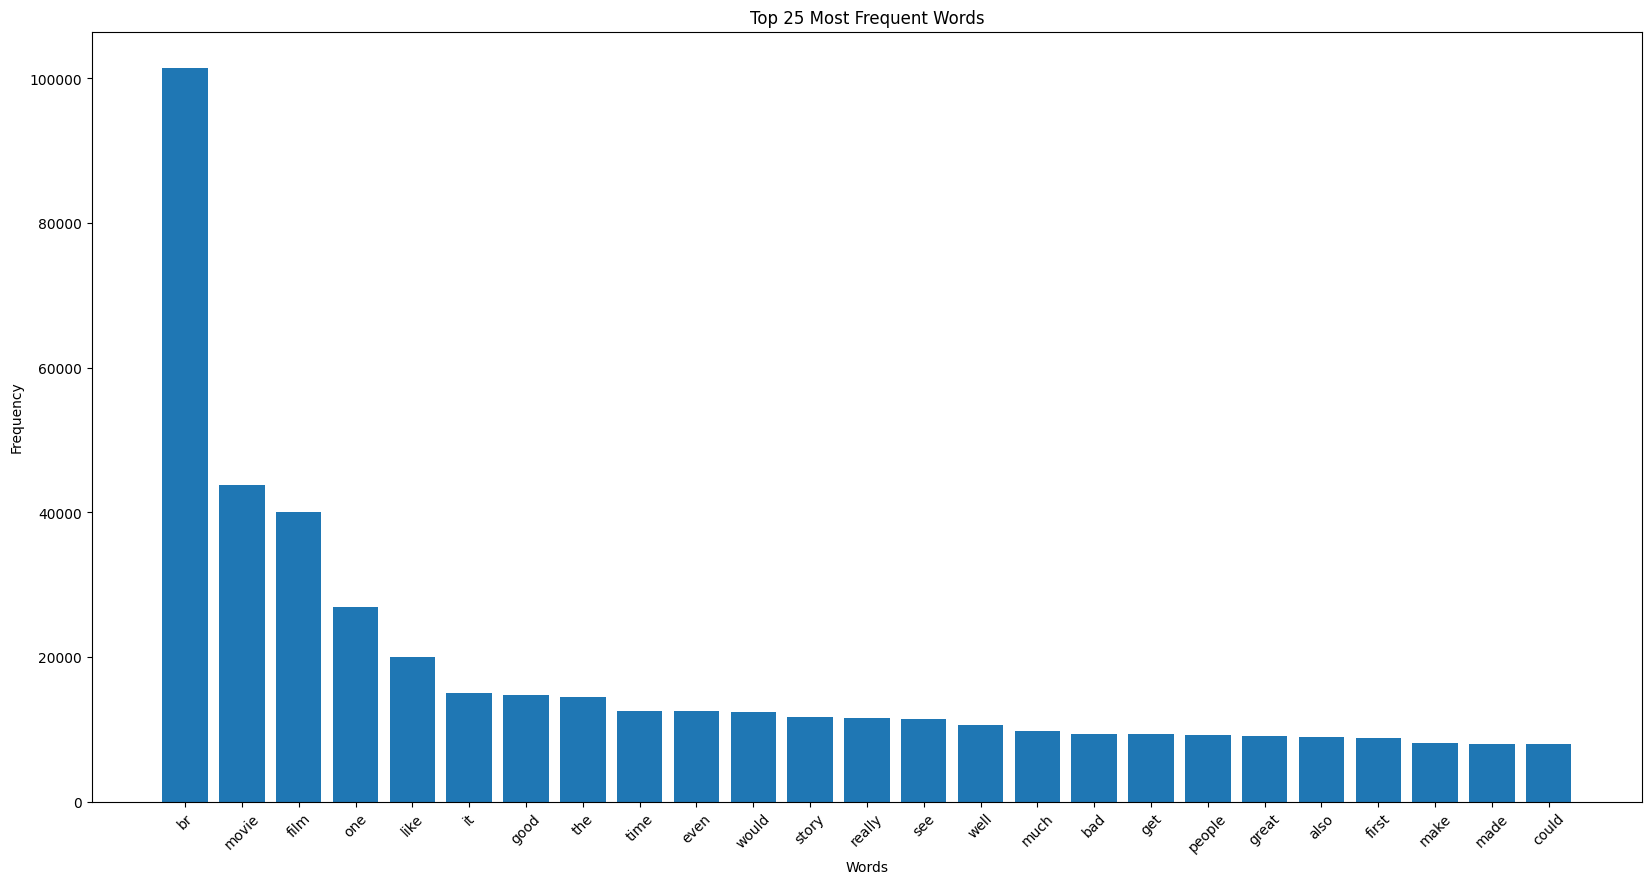

In [ ]:
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer

# Create CountVectorizer
vectorizer = CountVectorizer()

# Fit and transform the training data
X_train_counts = vectorizer.fit_transform(X_train)

# Get the feature names (words)
words = vectorizer.get_feature_names_out()

# Summarize word counts
word_counts = X_train_counts.sum(axis=0)

# Sort words by frequency
word_freq = [(word, word_counts[0, idx]) for word, idx in vectorizer.vocabulary_.items()]
word_freq.sort(key=lambda x: x[1], reverse=True)

# Plot the top N most frequent words
N = 25
top_words = [word[0] for word in word_freq[:N]]
top_freqs = [word[1] for word in word_freq[:N]]

plt.figure(figsize=(20, 10))
plt.bar(top_words, top_freqs)
plt.xlabel('Words')
plt.ylabel('Frequency')
plt.title('Top 25 Most Frequent Words')
plt.xticks(rotation=45)
plt.show()


## 2. Transverse Documnt - Inverse Document Frequency

`Tf` means `term-frequency` while `tf-idf` means `term-frequency times inverse document-frequency`. This is a common term weighting scheme in information retrieval, that has also found good use in document classification.

The goal of using tf-idf instead of the raw frequencies of occurrence of a token in a given document is to scale down the impact of tokens that occur very frequently in a given corpus and that are hence empirically less informative than features that occur in a small fraction of the training corpus.

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Initialize the TfidfVectorizer
vec = TfidfVectorizer(
    ngram_range=(1, 2),
    min_df=3,
    max_df=0.9,
    strip_accents='unicode',
    use_idf=1,
    smooth_idf=1,
    sublinear_tf=1,
    binary=1,
    stop_words='english'
)

# Fit and transform the training data
X_train_tfidf = vec.fit_transform(X_train)

# Transform the validation data
X_valid_tfidf = vec.transform(X_valid)

In [ ]:
# Check the shapes of the transformed data
print(X_train_vec.shape)
print(X_valid_vec.shape)

(25000, 76630)
(25000, 76630)


## 3. Word2vec Algorithm

`Word2Vec` is a popular algorithm for generating word embeddings. It represents words as dense vectors in a continuous vector space and captures semantic similarities between words by mapping them to nearby points in the vector space, allowing for effective analysis of word relationships and contexts.

**Skip-gram**: This model aims to predict the target word based on the context words surrounding it. It takes a window of context words as input and tries to predict the target word.
**Continuous Bag of Words (BoW)**: The CBOW model predicts context words given a target word. It takes a target word as input and tries to predict the context words within a specific window around the target word. CBOW is generally faster to train and works well with frequent words.

In this specific dataset, the Skip-gram model consistently outperformed the Continuous Bag of Words (CBOW) model across various machine learning algorithms. This is why I chose to include only the Skip-gram model in my notebook, as it demonstrated superior performance in capturing the semantic similarities between words.


In [ ]:
from gensim.models import Word2Vec
from nltk.tokenize import word_tokenize
from keras.preprocessing.sequence import pad_sequences
import numpy as np


# Tokenize the flattened text into sentences
sentences = [word_tokenize(review) for review in X_train]

# Train the Skip-gram Model
model = Word2Vec(sentences, min_count=1, vector_size=100, window=5, sg=1)

# Define function to generate embeddings
def generate_embeddings(sentence, model):
    embeddings = []
    for word in sentence:
        if word in model.wv.key_to_index:
            embeddings.append(model.wv[word])
    return embeddings


# Apply model to generate embeddings for each sentence in the flattened text
X_train_model = [generate_embeddings(sentence, model) for sentence in sentences]

# Flatten the embeddings
X_train_model_flat = [np.array(embeddings) for embeddings in X_train_model]

# Define the maximum sequence length (number of features per row)
max_sequence_length = 100

# Pad or truncate sequences to ensure fixed number of features per row

X_train_model_padded = pad_sequences(X_train_model_flat, maxlen=max_sequence_length, dtype='float32', padding='post', truncating='post', value=0.0)

# Ensure that you have 40000 outputs
X_train_model_padded = X_train_model_padded[:40000]


2024-05-30 11:22:38.498839: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-30 11:22:38.498964: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-30 11:22:38.619208: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [ ]:
# Tokenize the flattened text into sentences for validation data
sentences_valid = [word_tokenize(review) for review in X_valid]

# Apply model to generate embeddings for each sentence in the flattened validation text
X_valid_model = [generate_embeddings(sentence, model) for sentence in sentences_valid]

# Flatten the embeddings for validation data

X_valid_model_flat = [np.array(embeddings) for embeddings in X_valid_model]

# Pad or truncate sequences for validation data

X_valid_model_padded = pad_sequences(X_valid_model_flat, maxlen=max_sequence_length, dtype='float32', padding='post', truncating='post', value=0.0)


# Reshape the input array to flatten it

X_train_flattened = X_train_model_padded.reshape(X_train_model_padded.shape[0], -1)


X_valid_flattened = X_valid_model_padded.reshape(X_valid_model_padded.shape[0], -1)


In [ ]:
print(X_train_flattened.shape)


print(X_valid_flattened.shape)


(25000, 10000)
(25000, 10000)


## 4. GloVe Embeddings

I employed this `glove.6B.100d.txt` but the results were not promising. To save the memory of my notebook, I decided not to train this model on my dataset.

## 5. Sentence Transformers

**I used several algorithms from sentence transformers to generate embeddings. The embeddings were saved in a sepaarte dataset, from which I am using them for further annalysis. The algorithms are:**


### a. all-MiniLM-L6-v2
It is an all-around model tuned for many use cases and was trained on a large and diverse dataset of over 1 billion training pairs with six transformer layers. It is faster and still provides good-quality results. It takes a max_sequence_length of 256 and yeilds embeddings of 384-dimensions.
I have added the trained embeddings in this notebook to minimize memory usage

### b. bert-base-nli-mean-tokens¶

This transformer model is based on BERT and is trained to generate sentence embeddings by averaging the embeddings of all tokens in the input sentence. It is commonly used for sentence similarity, semantic search, and text classification tasks.

#### c. multi-qa-mpnet-base-dot-v1

This model is widely used for semantic search. Given a query/question, it finds relevant passages. It was trained on a large, diverse set of (question-answer) pairs, leveraging the MPNet architecture to capture nuanced semantic information across various contexts. It takes a maximum input of 512 sequence lengths, and sand produces word embeddings of 768 dimensions.

### d. roberta-large-nli-stsb-mean-tokens

roberta-large-nli-stsb-mean-tokens is a robust sentence transformer model based on the RoBERTa architecture, fine-tuned on Natural Language Inference (NLI) and the Semantic Textual Similarity Benchmark (STSB). This model produces highly accurate sentence embeddings using mean pooling of token embeddings.

In [ ]:
# Load embeddings into variables
imdb_miniLM_embeddings_1 = np.load('/kaggle/input/imdb-dataset-embeddings-by-sentence-transformers/imdb_dataset_df_1_embeddings(MiniLM).npy')
imdb_miniLM_embeddings_2 = np.load('/kaggle/input/imdb-dataset-embeddings-by-sentence-transformers/imdb_dataset_df_2_embeddings (MiniLM).npy')
imdb_multi_qa_embeddings_1 = np.load('/kaggle/input/imdb-dataset-embeddings-by-sentence-transformers/imdb_dataset_df_1_embeddings_multi-qa-mpnet-base-dot-v1.npy')
imdb_multi_qa_embeddings_2 = np.load('/kaggle/input/imdb-dataset-embeddings-by-sentence-transformers/imdb_dataset_df_2_embeddings_multi-qa-mpnet-base-dot-v1.npy')
imdb_roberta_large_embeddings_1 = np.load('/kaggle/input/imdb-dataset-embeddings-by-sentence-transformers/imdb_dataset_df_1_embeddings_roberta_large.npy')
imdb_roberta_large_embeddings_2 = np.load('/kaggle/input/imdb-dataset-embeddings-by-sentence-transformers/imdb_dataset_df_2_embeddings_roberta_large.npy')
imdb_bert_base_embeddings_1 = np.load('/kaggle/input/imdb-dataset-embeddings-by-sentence-transformers/imdb_dataset_df_1_embeddings(Bert-Base).npy')
imdb_bert_base_embeddings_2 = np.load('/kaggle/input/imdb-dataset-embeddings-by-sentence-transformers/imdb_dataset_df_2_embeddings(Bert-base).npy')


# D. Models Comaprison

## **MLPClassifier**

I used `MLPClassifier` with all the above word embeddings, which were generated using different vectors and word embedding algorithms. Surprisingly, the results were outstanding when I used `TF-IDF` word vectors, achieving an accuracy of `90%`, `CountVectorizer`: `88%` In contrast, the skip-gram word2 vec model yielded an accuracy of `76%`, and the CBOW model achieved `72%`. The sentence transformer embeddings performed very poorly with the logistic regression model, with an accuracy of just `50%`.

In [ ]:
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score

def train_and_eval_mlp(X_train, y_train, X_valid, y_valid):

    # Define the MLPClassifier model with early stopping
    model = MLPClassifier(hidden_layer_sizes=100, max_iter=100, random_state=42, early_stopping=True, validation_fraction=0.1, learning_rate_init=0.001)
    # Train the model
    clf = model.fit(X_train, y_train)

    # Make predictions
    predictions = clf.predict(X_valid)

    # Calculate the accuracy_score
    accuracy = accuracy_score(y_valid, predictions)

    # Print the accuracy
    print(f"Accuracy Score: {accuracy * 100:.2f}%")

    return accuracy

# Define the dataset names and corresponding data
dataset_names = [
    "CountVectorizer",
    "TF-IDF",
    "Skip-gram",
    "Sentence Transformer"
]
datasets = [
    (X_train_vec, y_train, X_valid_vec, y_valid),  # CountVectorizer
    (X_train_tfidf, y_train, X_valid_tfidf, y_valid),  # TF-IDF vectors
    (X_train_flattened, y_train, X_valid_flattened, y_valid), # Skip-gram vectors
    (imdb_multi_qa_embeddings_1, y_train, imdb_multi_qa_embeddings_2, y_valid) # sentence Transformer
]

# Apply MLPClassifier to all the datasets
mlp_accuracies = {}
for name, (X_train, y_train, X_valid, y_valid) in zip(dataset_names, datasets):
    print(f"Evaluating dataset with MLPClassifier: {name}")
    accuracy = train_and_eval_mlp(X_train, y_train, X_valid, y_valid)
    mlp_accuracies[name] = accuracy


Evaluating dataset with MLPClassifier: CountVectorizer
Accuracy Score: 89.16%
Evaluating dataset with MLPClassifier: TF-IDF
Accuracy Score: 90.27%
Evaluating dataset with MLPClassifier: Skip-gram
Accuracy Score: 79.96%
Evaluating dataset with MLPClassifier: Sentence Transformer
Accuracy Score: 49.81%


In [ ]:
# Create DataFrame from dictionary
df = pd.DataFrame.from_dict(mlp_accuracies, orient='index', columns=['Accuracy'])

# Set the index name
df.index.name = 'Model'

# Convert accuracies to percentages
df['Accuracy'] = df['Accuracy'] * 100

# Display DataFrame using tabulate
print("Summary of Logistic Regression accuracies:")
print(tabulate(df, headers='keys', tablefmt='pretty'))

Summary of Logistic Regression accuracies:
+----------------------+-------------------+
|        Model         |     Accuracy      |
+----------------------+-------------------+
|   CountVectorizer    |       89.16       |
|        TF-IDF        | 90.27199999999999 |
|      Skip-gram       |      79.964       |
| Sentence Transformer |      49.808       |
+----------------------+-------------------+


### MLPClassifier Performance Comparison with Different Word Vectors and Embeddings

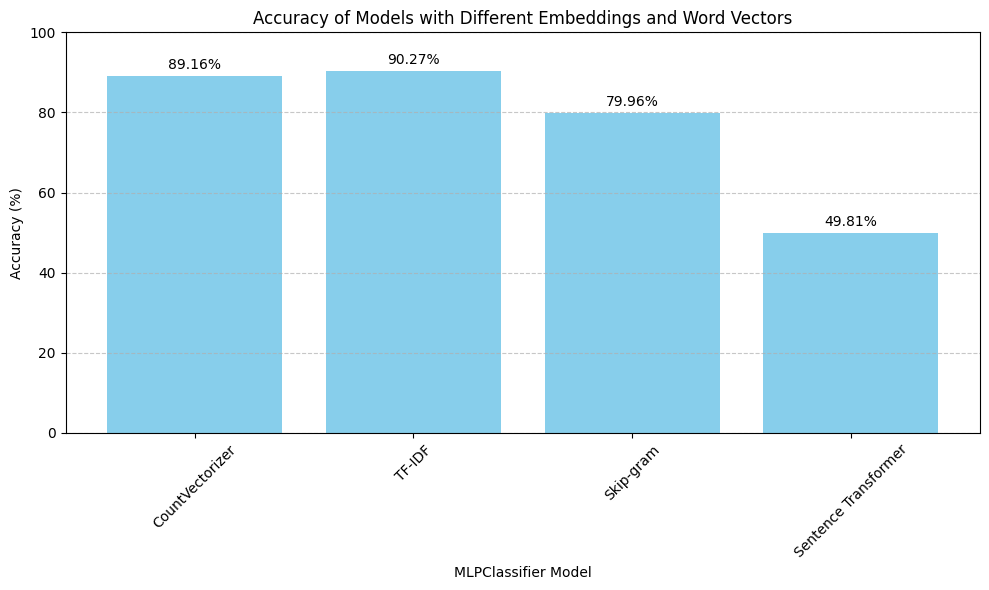

In [ ]:
models = list(mlp_accuracies.keys())
accuracies = [accuracy * 100 for accuracy in mlp_accuracies.values()]  # Format accuracies as percentages

# Create bar plot
plt.figure(figsize=(10, 6))
bars = plt.bar(models, accuracies, color='skyblue')

# Add percentage labels above each bar plot
for bar, accuracy in zip(bars, accuracies):
     plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 1, f'{accuracy:.2f}%', ha='center', va='bottom')

plt.xlabel('MLPClassifier Model')
plt.ylabel('Accuracy (%)')
plt.title('Accuracy of Models with Different Embeddings and Word Vectors')
plt.ylim(0, 100)  # Limit y-axis from 0 to 100
plt.xticks(rotation=45)  # Rotate x-axis labels for better visibility
plt.grid(axis='y', linestyle='--', alpha=0.7)  # Add horizontal gridlines
plt.tight_layout()  # Adjust layout to prevent clipping labels
plt.show()
